# Quantum Circuit Born Machine

Quantum circuit born machine is a fresh approach to quantum machine learning. It use a parameterized quantum circuit to learning machine learning tasks with gradient based optimization. In this tutorial, we will show how to implement it with **Yao** (幺) framework.


In [1]:
using Yao, GR

INFO: Recompiling stale cache file /Users/roger/.julia/lib/v0.6/Yao.ji for module Yao.


about the framework

In [2]:
?幺

search: 幺



Extensible Framework for Quantum Algorithm Design for Humans.

简单易用可扩展的量子算法设计框架。

幺 means unitary in Chinese.


## Training target
a gaussian distribution

In [3]:
function gaussian_pdf(n, μ, σ)
    x = collect(1:1<<n)
    pl = @. 1 / sqrt(2pi * σ^2) * exp(-(x - μ)^2 / (2 * σ^2))
    pl / sum(pl)
end

gaussian_pdf (generic function with 1 method)

\begin{equation}
f(x \left| \mu, \sigma^2\right) = \frac{1}{\sqrt{2\pi\sigma^2}} e^{-\frac{(x-\mu)^2}{2\sigma^2}}
\end{equation}

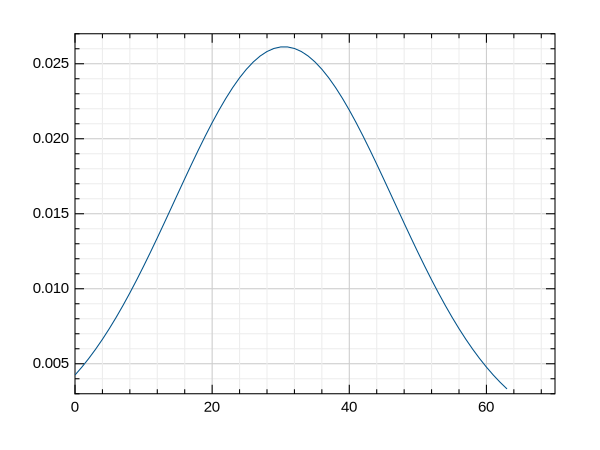

In [4]:
const n = 6
const maxiter = 20
pg = gaussian_pdf(n, 2^5-0.5, 2^4)
fig = plot(0:1<<n-1, pg)

# Build Circuits

## Building Blocks

Gates are grouped to become a layer in a circuit, this layer can be **Arbitrary Rotation** or **CNOT entangler**. Which are used as our basic building blocks of **Born Machines**.

### Arbitrary Rotation

Arbitrary Rotation is built with **Rotation Gate on Z**, **Rotation Gate on X** and **Rotation Gate on Z**:


\begin{equation}
Rz(\theta) \cdot Rx(\theta) \cdot Rz(\theta)
\end{equation}

Since our input will be a $|0\dots 0\rangle$ state. The first layer of arbitrary rotation can just use $Rx(\theta) \cdot Rz(\theta)$ and the last layer of arbitrary rotation could just use $Rz(\theta)\cdot Rx(\theta)$


In **幺**, every Hilbert operator is a **block** type, this includes all **quantum gates** and **quantum oracles**. In general, operators appears in a quantum circuit can be divided into **Composite Blocks** and **Primitive Blocks**.

We follow the low abstraction principle and thus each block represents a certain approach of calculation. The simplest **Composite Block** is a **Chain Block**, which chains other blocks (oracles) with the same number of qubits together. It is just a simple mathematical composition of operators with same size. e.g.

\begin{equation}
\text{chain(X, Y, Z)} \iff X \cdot Y \cdot Z
\end{equation}

We can construct an arbitrary rotation block by chain $Rz$, $Rx$, $Rz$ together.

In [5]:
chain(Rz(0), Rx(0), Rz(0))

Total: 1, DataType: Complex{Float64}
chain
├─ Rot Z gate: 0.0
├─ Rot X gate: 0.0
└─ Rot Z gate: 0.0


`Rx`, `Ry` and `Rz` will construct new rotation gate, which are just shorthands for `rot(X, 0.0)`, etc.

Then, let's pile them up vertically with another method called **rollrepeat**

In [6]:
layer(x::Symbol) = layer(Val(x))
layer(::Val{:first}) = rollrepeat(chain(Rx(0), Rz(0)))

layer (generic function with 2 methods)

In **幺**, the factory method **rollrepeat** will construct a block called **Roller**. It is mathematically equivalent to the kronecker product of all operators in this layer:

\begin{equation}
rollrepeat(n, U) \iff roll(n, \text{i=>U for i = 1:n}) \iff kron(n, \text{i=>U for i=1:n}) \iff U \otimes \dots \otimes U
\end{equation}

In [7]:
roll(4, i=>X for i = 1:4)

Total: 4, DataType: Complex{Float64}
roller
├─ X gate
├─ X gate
├─ X gate
└─ X gate


In [8]:
rollrepeat(4, X)

Total: 4, DataType: Complex{Float64}
roller
├─ X gate
├─ X gate
├─ X gate
└─ X gate


In [9]:
kron(4, i=>X for i = 1:4)

Total: 4, DataType: Complex{Float64}
kron
├─ 1=>X gate
├─ 2=>X gate
├─ 3=>X gate
└─ 4=>X gate


However, `kron` is calculated differently comparing to `roll`. In principal, **Roller** will be able to calculate small blocks with same size with higher efficiency. But for large blocks **Roller** may be slower. In **幺**, we offer you this freedom to choose the most suitable solution.


all factory methods will **lazy** evaluate **the first arguements**, which is the number of qubits. It will return a lambda function that requires a single interger input. The instance of desired block will only be constructed until all the information is filled.

In [10]:
rollrepeat(X)

(::#33) (generic function with 1 method)

In [11]:
rollrepeat(X)(4)

Total: 4, DataType: Complex{Float64}
roller
├─ X gate
├─ X gate
├─ X gate
└─ X gate


When you filled all the information in somewhere of the declaration, 幺 will be able to infer the others.

In [12]:
chain(4, rollrepeat(X), rollrepeat(Y))

Total: 4, DataType: Complex{Float64}
chain
├─ roller
│  ├─ X gate
│  ├─ X gate
│  ├─ X gate
│  └─ X gate
└─ roller
   ├─ Y gate
   ├─ Y gate
   ├─ Y gate
   └─ Y gate


We will now define the rest of rotation layers

In [13]:
layer(::Val{:last}) = rollrepeat(chain(Rz(0), Rx(0)))
layer(::Val{:mid}) = rollrepeat(chain(Rz(0), Rx(0), Rz(0)))

layer (generic function with 4 methods)

### CNOT Entangler

Another component of quantum circuit born machine is several **CNOT** operators applied on different qubits.

In [14]:
entangler(pairs) = chain(control([ctrl, ], target=>X) for (ctrl, target) in pairs)

entangler (generic function with 1 method)

We can then define such a born machine

In [15]:
function QCBM(n, nlayer, pairs)
    circuit = chain(n)
    push!(circuit, layer(:first))
    
    for i = 1:(nlayer - 1)
        push!(circuit, cache(entangler(pairs)))
        push!(circuit, layer(:mid))
    end
    
    push!(circuit, cache(entangler(pairs)))
    push!(circuit, layer(:last))
    
    circuit
end

QCBM (generic function with 1 method)

We use the method `cache` here to tag the entangler block that it should be cached after its first run, because it is actually a constant oracle. Let's see what will be constructed

In [16]:
QCBM(4, 1, [1=>2, 2=>3, 3=>4])

Total: 4, DataType: Complex{Float64}
chain
├─ roller
│  ├─ chain
│  │  ├─ Rot X gate: 0.0
│  │  └─ Rot Z gate: 0.0
│  ├─ chain
│  │  ├─ Rot X gate: 0.0
│  │  └─ Rot Z gate: 0.0
│  ├─ chain
│  │  ├─ Rot X gate: 0.0
│  │  └─ Rot Z gate: 0.0
│  └─ chain
│     ├─ Rot X gate: 0.0
│     └─ Rot Z gate: 0.0
├─ chain (Cached)
│  ├─ control(1)
│  │  └─ 2=>X gate
│  ├─ control(2)
│  │  └─ 3=>X gate
│  └─ control(3)
│     └─ 4=>X gate
└─ roller
   ├─ chain
   │  ├─ Rot Z gate: 0.0
   │  └─ Rot X gate: 0.0
   ├─ chain
   │  ├─ Rot Z gate: 0.0
   │  └─ Rot X gate: 0.0
   ├─ chain
   │  ├─ Rot Z gate: 0.0
   │  └─ Rot X gate: 0.0
   └─ chain
      ├─ Rot Z gate: 0.0
      └─ Rot X gate: 0.0


## MMD Loss & Gradients

The MMD loss is describe below:

\begin{equation}
\begin{aligned}
\mathcal{L} &= \left| \sum_{x} p \theta(x) \phi(x) - \sum_{x} \pi(x) \phi(x) \right|^2\\
            &= \langle K(x, y) \rangle_{x \sim p_{\theta}, y\sim p_{\theta}} - 2 \langle K(x, y) \rangle_{x\sim p_{\theta}, y\sim \pi} + \langle K(x, y) \rangle_{x\sim\pi, y\sim\pi}
\end{aligned}
\end{equation}


We will use a squared exponential kernel here.

In [17]:
struct Kernel
    sigma::Float64
    matrix::Matrix{Float64}
end

function Kernel(nqubits, sigma)
    basis = collect(0:(1<<nqubits - 1))
    Kernel(sigma, kernel_matrix(basis, basis, sigma))
end

expect(kernel::Kernel, px::Vector{Float64}, py::Vector{Float64}) = px' * kernel.matrix * py
loss(qcbm, kernel::Kernel, ptrain) = (p = get_prob(qcbm) - ptrain; expect(kernel, p, p))

loss (generic function with 1 method)

Next, let's define the kernel matrix

In [18]:
function kernel_matrix(x, y, sigma)
    dx2 = (x .- y').^2
    gamma = 1.0 / (2 * sigma)
    K = exp.(-gamma * dx2)
    K
end

kernel_matrix (generic function with 1 method)

### Gradients


the gradient of MMD loss is

\begin{equation}
\begin{aligned}
\frac{\partial \mathcal{L}}{\partial \theta^i_l} &= \langle K(x, y) \rangle_{x\sim p_{\theta^+}, y\sim p_{\theta}} - \langle K(x, y) \rangle_{x\sim p_{\theta}^-, y\sim p_{\theta}}\\
&- \langle K(x, y) \rangle _{x\sim p_{\theta^+}, y\sim\pi} + \langle K(x, y) \rangle_{x\sim p_{\theta^-}, y\sim\pi}
\end{aligned}
\end{equation}

We have to update one parameter of each rotation gate each time, and calculate its gradient then collect them. Since we will need to calculate the probability from the state vector frequently, let's define a shorthand first.


Firstly, you have to define a quantum register. Each run of a QCBM's input is a simple $|00\cdots 0\rangle$ state. We provide string literal `bit` to help you define one-hot state vectors like this

In [19]:
r = register(bit"0000")

DefaultRegister{1, Complex{Float64}}
    active qubits: 4/4

We provide two method to apply a block to a register:

    with(f, register)

This method declares a context that has no side-effect, which means rather than apply a block directly to a register, it will copy the register first and then apply the block to this copy.

    with!(f, register)

This method declares a context that will have side-effect, which means the block will be applied to the register directly.

In side the context you should use a pip `|>` to apply a block, which will looks like this:

In [20]:
our_register = register(bit"0"^5)

new_register = with(our_register) do r
    r |> kron(1=>X)
    r |> kron(2=>X)
end

state(new_register) ≈ state(our_register)

false

In [21]:
state(new_register) ≈ state(register(bit"00011"))

true

For convenience, we also provide the following interface, which allows you to apply a pre-defined circuit to a register.

    with(block, register)
    with!(block, register)

In [22]:
circuit = QCBM(6, 10, [1=>2, 3=>4, 5=>6, 2=>3, 4=>5, 6=>1]);
with(circuit, register(bit"0"^6))

DefaultRegister{1, Complex{Float64}}
    active qubits: 6/6

Now, we define its shorthand

In [23]:
get_prob(qcbm) = with!(qcbm, register(bit"0"^6)) |> statevec .|> abs2

get_prob (generic function with 1 method)

We will first iterate through each layer contains rotation gates and allocate an array to store our gradient

In [24]:
import Base: gradient

function gradient(n, nlayers, qcbm, kernel, ptrain)
    prob = get_prob(qcbm)
    grad = zeros(real(datatype(qcbm)), nparameters(qcbm))
    idx = 0
    for ilayer = 1:2:(2 * nlayers + 1)
        idx = grad_layer!(grad, idx, prob, qcbm, qcbm[ilayer], kernel, ptrain)
    end
    grad
end

gradient (generic function with 13 methods)

Then we iterate through each rotation gate.

In [25]:
function grad_layer!(grad, idx, prob, qcbm, layer, kernel, ptrain)
    count = idx
    for each_line in blocks(layer)
        for each in blocks(each_line)
            gradient!(grad, count+1, prob, qcbm, each, kernel, ptrain)
            count += 1
        end
    end
    count
end

grad_layer! (generic function with 1 method)

We update each parameter by rotate it $-\pi/2$ and $\pi/2$

In [26]:
function gradient!(grad, idx, prob, qcbm, gate, kernel, ptrain)
    dispatch!(+, gate, pi / 2)
    prob_pos = get_prob(qcbm)

    dispatch!(-, gate, pi)
    prob_neg = get_prob(qcbm)

    dispatch!(+, gate, pi / 2) # set back

    grad_pos = expect(kernel, prob, prob_pos) - expect(kernel, prob, prob_neg)
    grad_neg = expect(kernel, ptrain, prob_pos) - expect(kernel, ptrain, prob_neg)
    grad[idx] = grad_pos - grad_neg
    grad
end

gradient! (generic function with 1 method)

## Optimizer

We will use the Adam optimizer. Since we don't want you to install another package for this, the following code for this optimizer is copied from [Knet.jl](https://github.com/denizyuret/Knet.jl)

Reference: [Kingma, D. P., & Ba,
J. L. (2015)](https://arxiv.org/abs/1412.6980). Adam: a Method for
Stochastic Optimization. International Conference on Learning
Representations, 1–13.

In [27]:
mutable struct Adam
    lr::AbstractFloat
    gclip::AbstractFloat
    beta1::AbstractFloat
    beta2::AbstractFloat
    eps::AbstractFloat
    t::Int
    fstm
    scndm
end

Adam(; lr=0.001, gclip=0, beta1=0.9, beta2=0.999, eps=1e-8)=Adam(lr, gclip, beta1, beta2, eps, 0, nothing, nothing)

function update!(w, g, p::Adam)
    gclip!(g, p.gclip)
    if p.fstm===nothing; p.fstm=zeros(w); p.scndm=zeros(w); end
    p.t += 1
    BLAS.scale!(p.beta1, p.fstm)
    BLAS.axpy!(1-p.beta1, g, p.fstm)
    BLAS.scale!(p.beta2, p.scndm)
    BLAS.axpy!(1-p.beta2, g .* g, p.scndm)
    fstm_corrected = p.fstm / (1 - p.beta1 ^ p.t)
    scndm_corrected = p.scndm / (1 - p.beta2 ^ p.t)
    BLAS.axpy!(-p.lr, (fstm_corrected ./ (sqrt.(scndm_corrected) + p.eps)), w)
end

function gclip!(g, gclip)
    if gclip == 0
        g
    else
        gnorm = vecnorm(g)
        if gnorm <= gclip
            g
        else
            BLAS.scale!(gclip/gnorm, g)
        end
    end
end

gclip! (generic function with 1 method)

The training of the quantum circuit is simple, just iterate through the steps.

In [28]:
function train!(qcbm, ptrain, optim; learning_rate=0.1, niter=50)
    # initialize the parameters
    params = 2pi * rand(nparameters(qcbm))
    dispatch!(qcbm, params)
    kernel = Kernel(nqubits(qcbm), 0.25)
    
    n, nlayers = nqubits(qcbm), (length(qcbm)-1)÷2
    history = Float64[]
    
    for i = 1:niter
        grad = gradient(n, nlayers, qcbm, kernel, ptrain)
        curr_loss = loss(qcbm, kernel, ptrain)
        push!(history, curr_loss)        
        params = parameters(qcbm)
        update!(params, grad, optim)
        dispatch!(qcbm, params)
    end
    history
end

train! (generic function with 1 method)

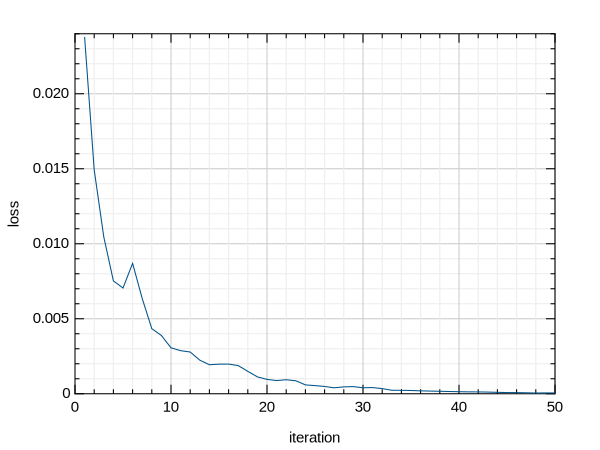

In [29]:
optim = Adam(lr=0.1)
his = train!(circuit, pg, optim, niter=50, learning_rate=0.1)
plot(1:50, his, xlabel="iteration", ylabel="loss")

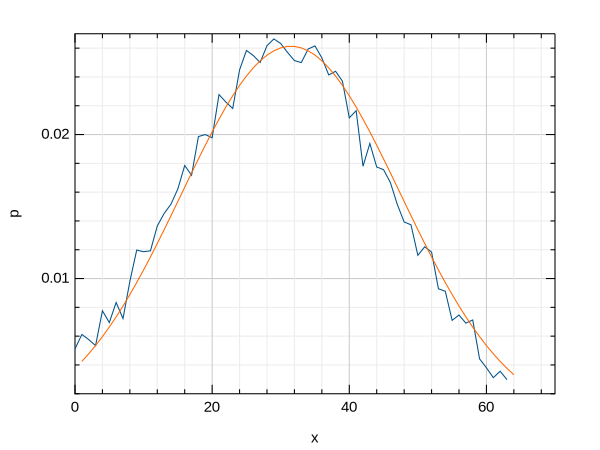

In [30]:
p = get_prob(circuit)
plot(0:1<<n-1, p, pg, xlabel="x", ylabel="p")